In [105]:
import numpy as np

def positionEstimatorTraining(trial):
    neurons = np.arange(0, 98)
    angleDECODED = 0
    P_cov = np.eye(6)
    K = np.zeros((6, len(neurons)))
    vx = 0
    vy = 0
    ax = 0
    ay = 0
    dt = 20

    ModelParameters = [{
        'A': None,
        'H': None,
        'W': None,
        'Q': None,
        'errorCovariance': P_cov,
        'kalmanGain': K,
        'direction': angleDECODED,
        'lambda': None,
        'velocity': [vx, vy],
        'acceleration': [ax, ay],
        'bayesian': None,
        'lambda2': None
    } for _ in range(8)]

    for angle in range(8):
        A_mean = np.zeros((6, 6))
        H_mean = np.zeros((len(neurons), 6))
        W_mean = np.zeros((6, 6))
        Q_mean = np.zeros((len(neurons), len(neurons)))

        for trl in range(len(trial)):
            positionx = trial[trl][angle]['handPos'][0][::dt]          
            positiony = trial[trl][angle]['handPos'][1][::dt]
            
            velocityx = np.diff(positionx) / dt
            velocityy = np.diff(positiony) / dt
            # Prepend '0' to velocityx and velocityy
            velocityx = np.insert(velocityx, 0, 0)
            velocityy = np.insert(velocityy, 0, 0)

            accelerationx = np.diff(velocityx) / dt
            accelerationy = np.diff(velocityy) / dt
            # Prepend '0' to accelerationx and accelerationy
            accelerationx = np.insert(accelerationx, 0, 0)
            accelerationy = np.insert(accelerationy, 0, 0)


            X = np.array([
                positionx[1:],
                positiony[1:],
                velocityx[1:],
                velocityy[1:],
                accelerationx[1:],
                accelerationy[1:]
            ])

            X2 = X[:, 1:]
            X1 = X[:, :-1]
            A = np.dot(X2, X1.T) @ np.linalg.pinv(X1 @ X1.T)

            #Z = np.zeros((len(neurons), len(X.T)))

            Z = []
            for neuron in range(len(neurons)):
                firingRate = np.array([sum(trial[trl][angle]['spikes'][neurons[neuron], k:k+dt]) for k in range(0, len(trial[trl][angle]['spikes'][neurons[neuron]])-dt, dt)])
                Z.append(firingRate)

            H = np.dot(Z, X.T) @ np.linalg.pinv(X @ X.T)

            W = np.dot((X2 - A @ X1), (X2 - A @ X1).T) / len(accelerationx)
            Q = np.dot((Z - H @ X), (Z - H @ X).T) / len(accelerationx)

            A_mean += A
            H_mean += H
            W_mean += W
            Q_mean += Q

        A_mean /= len(trial)
        H_mean /= len(trial)
        W_mean /= len(trial)
        Q_mean /= len(trial)

        ModelParameters[angle]['A'] = A_mean
        ModelParameters[angle]['H'] = H_mean
        ModelParameters[angle]['W'] = W_mean
        ModelParameters[angle]['Q'] = Q_mean

    lambda_values = np.zeros((len(neurons), 8))
    lambda2_values = np.zeros((len(neurons), 8))

    for angle in range(8):
        for neuron in range(len(neurons)):
            lambda_values[neuron, angle] = np.mean([sum(trial[trl][angle]['spikes'][neurons[neuron], 50:320]) for trl in range(len(trial))])
            lambda2_values[neuron, angle] = np.mean([sum(trial[trl][angle]['spikes'][neurons[neuron], 50:340]) for trl in range(len(trial))])

    ModelParameters[0]['lambda'] = lambda_values
    ModelParameters[0]['lambda2'] = lambda2_values

    return ModelParameters


In [106]:
import numpy as np

def positionEstimator(trial, ModelParameters):
    dt = 20


    if trial['spikes'].shape[1] == 320:
        angleDECODED = ModelParameters[0]['direction']
        starting = trial['startHandPos']
        x = np.array([starting[0], starting[1], 0, 0, 0, 0])
        ModelParameters[0]['errorCovariance'] = np.eye(6)
        neurons = np.arange(1, 99)
        ModelParameters[0]['kalmanGain'] = np.zeros((6, len(neurons)))
    elif trial['spikes'].shape[1] != 320:
        angleDECODED = ModelParameters[0]['direction']
        A = ModelParameters[angleDECODED]['A']
        H = ModelParameters[angleDECODED]['H']
        W = ModelParameters[angleDECODED]['W']
        Q = ModelParameters[angleDECODED]['Q']
        Pcov_error = ModelParameters[0]['errorCovariance']
        K = ModelParameters[0]['kalmanGain']
        velocity = ModelParameters[0]['velocity']
        acceleration = ModelParameters[0]['acceleration']

        

        decoded = trial['decodedHandPos'][-1]
        print(decoded)
        x = np.array([decoded[0], decoded[1], velocity[0], velocity[1], acceleration[0], acceleration[1]])

        time = trial['spikes'].shape[1] - dt
        neurons = np.arange(0, 98)

        firingRateTest = np.zeros(len(neurons))
        for neuron in range(len(neurons)):
            n = np.sum(trial['spikes'][neurons[neuron], time:time+dt])
            firingRateTest[neuron] = n

        x_Prior = np.dot(A, x)
        Pcov_error = np.dot(np.dot(A, Pcov_error), np.transpose(A)) + W

        K = np.dot(np.dot(Pcov_error, np.transpose(H)), np.linalg.pinv(np.dot(np.dot(H, Pcov_error), np.transpose(H)) + Q))
        
        x = x_Prior + np.dot(K, firingRateTest - np.dot(H, x_Prior))
        Pcov_error = np.dot(np.eye(A.shape[0]) - np.dot(K, H), Pcov_error)

        ModelParameters[0]['errorCovariance'] = Pcov_error
        ModelParameters[0]['kalmanGain'] = K
        ModelParameters[0]['direction'] = angleDECODED
        ModelParameters[0]['velocity'] = [x[2], x[3]]
        ModelParameters[0]['acceleration'] = [x[4], x[5]]

    x1, y1 = x[0], x[1]
    return x1, y1, ModelParameters


Testing the continuous position estimator...
(1, 8)
(99, 8)
Decoding block 1 out of 1
(98, 671)
[-2.14209708 -8.20593082]
[-2.14209708 -8.20593082]
[-5.19459206 -3.84033218]
[-5.19459206 -3.84033218]
[-13.82260536  -3.04244607]
[-13.82260536  -3.04244607]
[-25.69446484  -5.20343737]
[-25.69446484  -5.20343737]
[-39.82477164  -6.73079371]
[-39.82477164  -6.73079371]
[-46.74152382  -8.44594646]
[-46.74152382  -8.44594646]
[-59.25886596 -10.19001161]
[-59.25886596 -10.19001161]
[-73.01278063 -12.77110828]
[-73.01278063 -12.77110828]
[-85.78108851 -14.22424654]
[-85.78108851 -14.22424654]
[-94.75725092 -17.04291514]
[-94.75725092 -17.04291514]
[-102.86672368  -18.31274893]
[-102.86672368  -18.31274893]
[-110.17183121  -18.96242073]
[-110.17183121  -18.96242073]
(98, 628)
[-8.83533684 -3.00342649]
[-8.83533684 -3.00342649]
[-6.43818353  8.31407447]
[-6.43818353  8.31407447]
[ 4.30377281 17.02808757]
[ 4.30377281 17.02808757]
[13.80563582 20.42150884]
[13.80563582 20.42150884]
[21.95431688 2

AttributeError: 'list' object has no attribute 'shape'

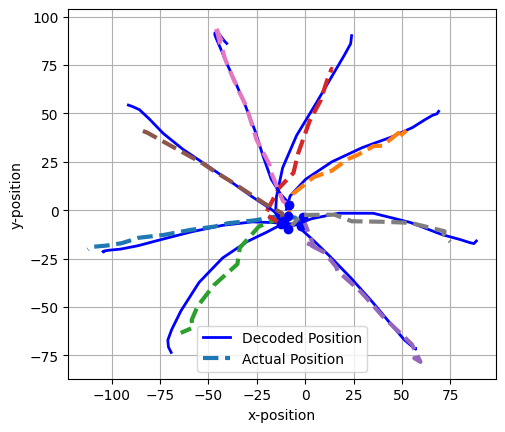

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.io import loadmat

# Load the .mat file
mat_data = loadmat('monkeydata_training.mat')

# Extract the 'trial' data
trial_data = mat_data['trial']

# Convert to a Python dictionary
trial_dict = {'trial': trial_data}

print('Testing the continuous position estimator...')

meanSqError = 0
n_predictions = 0

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.grid(True)
count = 1

ix = np.random.permutation(len(trial))

# Split the data into training and test sets
trainingData = trial_dict['trial'][:99]
testData = trial_dict['trial'][99:100]

# Train Model
model_parameters = positionEstimatorTraining(trainingData)
print(testData.shape)
print(trainingData.shape)

Angles = []

for tr in range(testData.shape[0]):
    print(f'Decoding block {tr + 1} out of {testData.shape[0]}')

    for direc in np.random.permutation(8):
        decodedHandPos = []
        print(testData[tr][direc]['spikes'].shape)
        times = np.arange(320, testData[tr][direc]['spikes'].shape[1] - 100, 20)
        model_parameters[0]['direction'] = direc

        for t in times:
            past_current_trial = {
                'trialId': testData[tr][direc]['trialId'],
                'spikes': testData[tr][direc]['spikes'][:, :t],
                'decodedHandPos': decodedHandPos,
                'startHandPos': testData[tr][direc]['handPos'][:2, 0]
            }

            # Decode Model
            if len(positionEstimator(past_current_trial, model_parameters)) == 3:
                decodedPosX, decodedPosY, newParameters = positionEstimator(past_current_trial, model_parameters)
                modelParameters = newParameters
            else:
                decodedPosX, decodedPosY = positionEstimator(past_current_trial, model_parameters)
                
            decodedPos = np.array([decodedPosX, decodedPosY])

            decodedHandPos.append(decodedPos)

            meanSqError += np.linalg.norm(testData[tr][direc]['handPos'][:2, t] - decodedPos)**2

        n_predictions += len(times)

        ax.plot(testData[tr][direc]['handPos'][0, times], testData[tr][direc]['handPos'][1, times], 'b', linewidth=2)
        ax.plot(np.array(decodedHandPos)[:, 0], np.array(decodedHandPos)[:, 1], '--', linewidth=3)
        ax.plot(decodedHandPos[0][0], decodedHandPos[0][1], 'bo')

        ax.set_xlabel('x-position')
        ax.set_ylabel('y-position')

        Angles.append([direc, tr, testData[tr][direc]['trialId'], modelParameters[0]['direction'],
                            testData[tr][direc]['spikes'].shape[1]])
        count += 1

plt.legend(['Decoded Position', 'Actual Position'])

# Check accuracy
RMSE = np.sqrt(meanSqError / n_predictions)

aa = np.zeros(Angles.shape[1])
for i in range(Angles.shape[1]):
    aa[i] = (Angles[0, i] - Angles[3, i]) == 0

accuracy = np.sum(aa) / Angles.shape[1]

# Set x-axis tick labels
# ax.set_xticklabels(['Step 1', 'Step 2', 'strawberries', 'pears'])

plt.show()

 

In [ ]:
print(trainingData)

[[(array([[111]], dtype=uint8), array([[1, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[-13.47083333, -13.46852386, -13.46541717, ...,  75.65101817,
           75.67271444,  75.69340087],
         [ -8.0225    ,  -8.02420787,  -8.02519673, ...,  45.41279603,
           45.36416882,  45.31664636],
         [-17.89333333, -17.89299333, -17.89293732, ..., -18.11325884,
          -18.11279044, -18.11238267]]))
  (array([[78]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 1, ..., 0, 0, 0],
         [0, 0, 0, ..., 1, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[-16.36300756, -16.36583637, -16.36849028, ...,  23.94384424,
           24.01422192,  24.08239399],
         [ -9.65579833,  -9.6564768 ,